In [37]:
import numpy as np
# feature extracture (mfcc) + load wave files
import librosa
# walking on the wave files with different names
import os 
from tqdm import tqdm_notebook as tqdm

import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 12)
from IPython import display
import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras import layers, models, activations, optimizers, losses
from keras.models import Model

from sklearn.metrics import confusion_matrix, classification_report

In [104]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [38]:
# getting the name of files without extention
# os.path.splitext(os.path.basename('/content/DR1FCJF0SA1.WAV'))[0]

In [39]:
#useing to load dataset
loadProccedData = True

In [40]:
# download TIMIT DB
if loadProccedData == False:
  !wget cls.ru.nl/~ltenbosch/TIMIT.tar.gz

In [41]:
# unzip files
if loadProccedData == False:
  !tar -zxvf /content/TIMIT.tar.gz

In [42]:
if loadProccedData == False:
  trainPhonesFeatures = []
  trainPhonesLabels = []
  trainDialectRegion = []
  trainSpeakerID = []
  counterCheck = 0
  pathBase = '/content/wavfiles16kHz/TRAIN/'
  # walking on all files
  for path in tqdm(os.listdir(pathBase)):
    # counterCheck += 1
    # if counterCheck == 10 :
    #   break
    wavFile, sampleRate = librosa.load(pathBase+path)
    sampleRate = 16000
    # extracting features 
    wavMfccFeatures = librosa.feature.mfcc(y=wavFile, sr=sampleRate, n_mfcc=13, hop_length=160)
    # path of text files (.PHN)
    # print(len(wavFile)/sampleRate * 100)
    # print(np.shape(wavMfccFeatures))
    pathToPhn = '/content/PHN/TRAIN/' + os.path.splitext(os.path.basename(path))[0] + '.PHN'
    dialectRegion = path[0:3]

    with open(pathToPhn) as f:
      line = f.readline()
      while line:
        start, end, phoneName = line.split(sep=' ')
        trainPhonesLabels.append(phoneName)
        trainDialectRegion.append(dialectRegion)
        #changing start and end of phones into centi_second
        start = np.floor(int(start) / sampleRate * 100).astype(np.int)
        end = np.floor(int(end) / sampleRate * 100).astype(np.int)
        #getting feature slice
        phoneFeatures = wavMfccFeatures[:,start:end]
        trainPhonesFeatures.append(phoneFeatures)
        #next line
        line = f.readline()



In [43]:
if loadProccedData == False:
  testPhonesFeatures = []
  testPhonesLabels = []
  testDialectRegion = []
  testSpeakerID = []
  counterCheck = 0
  pathBase = '/content/wavfiles16kHz/TEST/'
  # walking on all files
  for path in tqdm(os.listdir(pathBase)):
    # counterCheck += 1
    # if counterCheck == 10 :
    #   break
    wavFile, sampleRate = librosa.load(pathBase+path)
    sampleRate = 16000
    # extracting features 
    wavMfccFeatures = librosa.feature.mfcc(y=wavFile, sr=sampleRate, n_mfcc=13, hop_length=160)
    # path of text files (.PHN)
    # print(len(wavFile)/sampleRate * 100)
    # print(np.shape(wavMfccFeatures))
    pathToPhn = '/content/PHN/TEST/' + os.path.splitext(os.path.basename(path))[0] + '.PHN'
    dialectRegion = path[0:3]

    with open(pathToPhn) as f:
      line = f.readline()
      while line:
        start, end, phoneName = line.split(sep=' ')
        testPhonesLabels.append(phoneName)
        testDialectRegion.append(dialectRegion)
        #changing start and end of phones into centi_second
        start = np.floor(int(start) / sampleRate * 100).astype(np.int)
        end = np.floor(int(end) / sampleRate * 100).astype(np.int)
        #getting feature slice
        phoneFeatures = wavMfccFeatures[:,start:end]
        testPhonesFeatures.append(phoneFeatures)
        #next line
        line = f.readline()



In [44]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [45]:
#saving the variables
if loadProccedData == False:
  AllVars = [trainPhonesFeatures, trainPhonesLabels, trainDialectRegion, trainSpeakerID,
            testPhonesFeatures, testPhonesLabels, testDialectRegion, testSpeakerID]
  with open('/content/gdrive/MyDrive/Dataset/TIMITData/' + 'DS.pckl', 'wb') as f:
      pickle.dump(AllVars, f)

In [46]:
#load the variables
if loadProccedData:
  with open('/content/gdrive/MyDrive/Dataset/TIMITData/' + 'DS.pckl', 'rb') as f:
    [trainPhonesFeatures, trainPhonesLabels,
    trainDialectRegion, trainSpeakerID,
    testPhonesFeatures, testPhonesLabels, 
    testDialectRegion, testSpeakerID] = pickle.load(f)

In [47]:
# check the number of phones which have the length less than 7
c = 0
for ph in trainPhonesFeatures:
  if np.size(ph, axis=1) < 7:
    c += 1

print ('the number of phones with len less than 7 =', c)
# as there are almost half of training data with len less than 7 we should use padding

the number of phones with len less than 7 = 85162


In [48]:
w = set(trainPhonesLabels)
print(w)
# the number of training data
trainNumbers = len(trainPhonesLabels)
# the number of test data
testNumbers = len(testPhonesLabels)
print('the number of training data = ', trainNumbers)
print('the number of test data = ', testNumbers)

{'aa\n', 'aw\n', 'jh\n', 'uh\n', 'z\n', 'eh\n', 't\n', 'd\n', 'el\n', 'eng\n', 'ah\n', 'oy\n', 'ax-h\n', 'q\n', 'zh\n', 'ix\n', 'gcl\n', 'ch\n', 's\n', 'f\n', 'kcl\n', 'r\n', 'g\n', 'tcl\n', 'ih\n', 'n\n', 'th\n', 'ao\n', 'ay\n', 'ae\n', 'k\n', 'ey\n', 'iy\n', 'dcl\n', 'w\n', 'b\n', 'dx\n', 'ng\n', 'sh\n', 'ux\n', 'em\n', 'y\n', 'axr\n', 'ax\n', 'm\n', 'epi\n', 'pau\n', 'er\n', 'h#\n', 'en\n', 'hv\n', 'l\n', 'dh\n', 'v\n', 'uw\n', 'nx\n', 'hh\n', 'p\n', 'bcl\n', 'ow\n', 'pcl\n'}
the number of training data =  177080
the number of test data =  64145


In [49]:
# #check some parameters
# yyy, sr = librosa.load('/content/DR1FCJF0SA1.WAV')
# sr = 16000
# print('length of first wav file: ', len(yyy))
# print('sample rate: ', sr)
# print('length of wav file: ', len(yyy)/sr)
# print('N is: ', len(yyy)/sr*100)
# x = librosa.feature.mfcc(y=yyy, sr=sr)
# print('with default hyperparameters: ', np.shape(x))
# x = librosa.feature.mfcc(y=yyy, sr=sr , n_mfcc=13, hop_length=160)
# print('after tuning hyperparameters: ', np.shape(x))

In [50]:
# yyy, sr = librosa.load('/content/DR1FCJF0SA2.WAV')
# sr = 16000
# print(len(yyy)/sr * 100)
# x = librosa.feature.mfcc(y=yyy, sr=sr , n_mfcc=13, hop_length=160)
# print(np.shape(x))

In [51]:
# yyy, sr = librosa.load('/content/DR1FCJF0SI648.WAV')
# sr = 16000
# print(len(yyy)/sr * 100)
# x = librosa.feature.mfcc(y=yyy, sr=sr , n_mfcc=13, hop_length=160)
# print(np.shape(x))

##Labling the phones

\begin{array}{|c|c|c|c}\hline
\mathcal{\#} & \mathcal{Phone Class} & \mathcal{\# labels} & \mathcal{TIMIT labels} \\ \hline
  l1 & Vowel/Semivowel(VS) & 25 & aa \ ae \ ah \ ao \ aw \ ax \ axh \ axr \ ay \ eh \ er \ ey \ ih \ ix \ iy \ ow \ oy \ uh \ uw \ ux \ el \ l \ r \ w \ y \\ \hline
  l2 & Nasal/Flap(NF) & 8 & em \ en \ eng \ m \ n \ ng \ nx \ dx \\ \hline
  l3 & Strong Fracative(SF) & 6 & s \ z \ sh \ zh \ ch \ jh \\ \hline
  l4 & Weak Fricative(Wf) & 6 & v \ f \ dh \ th \ hh \ hv \\ \hline
  l5 & Stop(ST) & 6 & d \ b \ g \ p\ t\ k \\ \hline
  l6 & Closure (CL) & 9 & bcl \ dcl \ gcl \ pcl \ tcl \ kcl \ epi \ pau \ h\# \\ \hline \hline
  l7 & Sonorant(SON) & 33 & Vowel/Semivowel + Nasal/Flap \\ \hline
  l8 & Obstruent (OBS) & 18 & Strong Fric + Weak Fric + Stop\\ \hline
  l9 & Silence (SIL) & 9 & Same as Closure\\ \hline
  \end{array}

In [52]:
phLabels = {0: ['aa\n', 'ae\n', 'ah\n', 'ao\n', 'aw\n', 'ax\n', 'axh\n', 'axr\n',
                  'ay\n', 'eh\n', 'er\n', 'ey\n', 'ih\n', 'ix\n', 'iy\n', 'ow\n', 
                   'oy\n', 'uh\n', 'uw\n', 'ux\n', 'el\n', 'l\n', 'r\n', 'w\n', 'y\n']
            ,1: ['em\n', 'en\n', 'eng\n', 'm\n', 'n\n', 'ng\n', 'nx\n', 'dx\n']
            ,2: ['s\n', 'z\n', 'sh\n', 'zh\n', 'ch\n', 'jh\n']
            ,3: ['v\n', 'f\n', 'dh\n', 'th\n', 'hh\n', 'hv\n']
            ,4: ['d\n', 'b\n', 'g\n', 'p\n', 't\n', 'k\n']
            ,5: ['bcl\n', 'dcl\n', 'gcl\n', 'pcl\n', 'tcl\n', 'kcl\n', 'epi\n', 'pau\n', 'h#\n']
            }

In [53]:
# phLabels[0]

In [54]:
# phLabels = {'l1': ['aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'axh', 'axr', 'ay', 'eh', 
#                 'er', 'ey', 'ih', 'ix', 'iy', 'ow', 'oy', 'uh', 'uw', 'ux', 'el',
#                  'l', 'r', 'w', 'y']
#             ,'l2': ['em', 'en', 'eng', 'm', 'n', 'ng', 'nx', 'dx']
#             ,'l3': ['s', 'z', 'sh', 'zh', 'ch', 'jh']
#             ,'l4': ['v', 'f', 'dh', 'th', 'hh', 'hv']
#             ,'l5': ['d', 'b', 'g', 'p', 't', 'k']
#             ,'l6': ['bcl', 'dcl', 'gcl', 'pcl', 'tcl', 'kcl', 'epi', 'pau', 'h#']
#             }

In [55]:
# assigning the labels to one of 6 classes
# for training data
trainPhoneLabelsConverted = np.zeros((trainNumbers), dtype=np.int)
cnt = 0
for label in trainPhonesLabels:
  for i in range(6):
    if label in phLabels[i]:
      trainPhoneLabelsConverted[cnt] = i
      cnt += 1
      break
print(set(trainPhoneLabelsConverted))

{0, 1, 2, 3, 4, 5}


In [56]:
# for test data
testPhoneLabelsConverted = np.zeros((testNumbers), dtype=np.int)
cnt = 0
for label in testPhonesLabels:
  for i in range(6):
    if label in phLabels[i]:
      testPhoneLabelsConverted[cnt] = i
      cnt += 1
      break
print(set(testPhoneLabelsConverted))

{0, 1, 2, 3, 4, 5}


In [57]:
#preprocessing on mfcc_features stacking size 
cntTrain = 0
for ph in trainPhonesFeatures:
  cntTrain += np.size(ph, axis=1) // 7
  if np.size(ph, axis=1) % 7 != 0:
    cntTrain += 1

print(cntTrain)
# for instnace for len(ph) = 15 we have 3 frames of size 13*7 = 91

cntTest = 0
for ph in testPhonesFeatures:
  cntTest += np.size(ph, axis=1) // 7
  if np.size(ph, axis=1) % 7 != 0:
    cntTest += 1

print(cntTest)

277249
101012


In [58]:
# we should have 277249 training data with dimention 299391*91
Xtr = np.zeros((cntTrain, 91))
ytr = np.zeros((cntTrain))
i = 0 # for counting train phones (transfering labels)
j = 0 # for counting splited training phones

for ph in trainPhonesFeatures:
  while np.size(ph, axis=1) >= 7:
    temp = ph[:, 0:7]
    Xtr[j] = temp.flat #adding first 7 columns to Xtrain as supervector
    ytr[j] = trainPhoneLabelsConverted[i]
    j += 1
    ph = np.delete(ph, range(7), axis=1)
  if np.size(ph, axis=1) != 0:
    temp = ph.flat
    Xtr[j, 0:len(temp)] = temp
    j += 1
  i += 1

In [59]:
# we should have 101012 test data with dimention 299391*91
Xtst = np.zeros((cntTest, 91))
ytst = np.zeros((cntTest))
i = 0 # for counting test phones (transfering labels)
j = 0 # for counting splited test phones

for ph in testPhonesFeatures:
  while np.size(ph, axis=1) >= 7:
    temp = ph[:, 0:7]
    Xtst[j] = temp.flat #adding first 7 columns to Xtest as supervector
    ytst[j] = trainPhoneLabelsConverted[i]
    j += 1
    ph = np.delete(ph, range(7), axis=1)
  if np.size(ph, axis=1) != 0:
    temp = ph.flat
    Xtst[j, 0:len(temp)] = temp
    j += 1
  i += 1

##Biulding the Network

In [73]:
#one_hot the labels
nClasses = 6
ytrOneHot = tf.keras.utils.to_categorical(ytr, num_classes=nClasses, dtype='float32')

tf.Tensor([209373.  11773.  10912.   6888.  13532.  24771.], shape=(6,), dtype=float32)


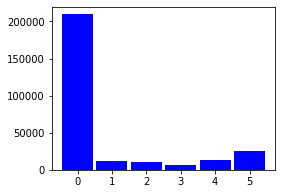

In [103]:
one_hot_labels = np.array(ytrOneHot)
count_label = tf.reduce_sum(one_hot_labels, axis=0)
print(count_label) 
fig = plt.figure(figsize=(4, 3))
bar_width = 0.9
p1 = plt.bar(np.arange(6), count_label, bar_width, color='b', label='John')

In [61]:
def build_neural_network(data_size_in, n_classes):
    
    # He is more compatible with relu and Glorot is more adjustable with tanh
    initializer = tf.keras.initializers.HeUniform()

    inputs = layers.Input(shape=data_size_in)

    x = layers.Conv1D(16, kernel_size=5, activation='relu', kernel_initializer=initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.MaxPool1D(pool_size=2)(x)
    # x = layers.Conv1D(32, kernel_size=5, activation='relu', kernel_initializer=initializer)(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.5)(x)
    # x = layers.MaxPool1D(pool_size=2)(x)
    # x = layers.Conv1D(64, kernel_size=5, activation='relu', kernel_initializer=initializer)(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.5)(x)
    # x = layers.MaxPool1D(pool_size=2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(32, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.5)(x)
    prediction = layers.Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())
    
    return model

In [62]:
#compile the model
data_size_in = (91, 1)   #13*7
n_classes = 6   #we have 6 different labels
ls = 'CategoricalCrossentropy'
opt = optimizers.Adam(learning_rate=0.01, beta_1=0.92)

network = build_neural_network(data_size_in, n_classes)
network.compile(loss=ls, optimizer=opt, metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 91, 1)]           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 87, 16)            96        
_________________________________________________________________
batch_normalization_3 (Batch (None, 87, 16)            64        
_________________________________________________________________
dropout_5 (Dropout)          (None, 87, 16)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 43, 16)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 688)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2204

Epoch 1/16
1950/1950 [==============================] - 7s 3ms/step - loss: 0.7156 - accuracy: 0.7453 - val_loss: 0.6102 - val_accuracy: 0.8072
Epoch 2/16
1950/1950 [==============================] - 6s 3ms/step - loss: 0.6801 - accuracy: 0.7509 - val_loss: 0.6086 - val_accuracy: 0.8072
Epoch 3/16
1950/1950 [==============================] - 6s 3ms/step - loss: 0.6807 - accuracy: 0.7507 - val_loss: 0.6110 - val_accuracy: 0.8072
Epoch 4/16
1950/1950 [==============================] - 6s 3ms/step - loss: 0.6825 - accuracy: 0.7494 - val_loss: 0.6120 - val_accuracy: 0.8072
Epoch 5/16
1950/1950 [==============================] - 6s 3ms/step - loss: 0.6819 - accuracy: 0.7500 - val_loss: 0.6116 - val_accuracy: 0.8072
Epoch 6/16
1950/1950 [==============================] - 6s 3ms/step - loss: 0.6863 - accuracy: 0.7479 - val_loss: 0.6126 - val_accuracy: 0.8072
Epoch 7/16
1950/1950 [==============================] - 6s 3ms/step - loss: 0.6846 - accuracy: 0.7482 - val_loss: 0.6074 - val_accuracy:

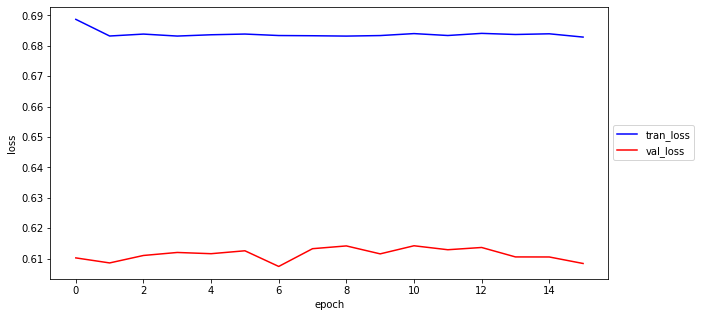

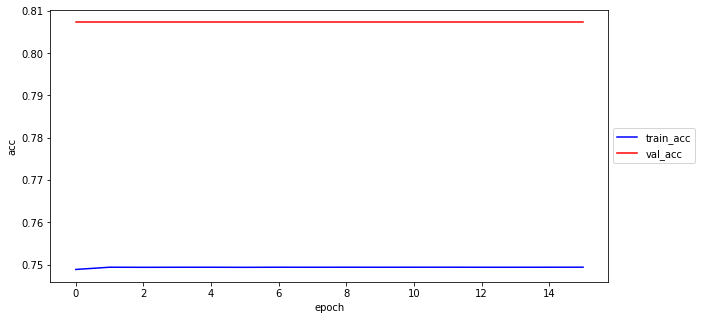

In [63]:
#feed the network
# lists where we will be storing values during training, for visualization purposes
traLosses = [] # list for training loss
traAccs = [] # list for training accuracy
valLosses = [] # list for validation loss
valAccs = [] # list for validation accuracy
batchSize = 128
nEpochs = 16

# Train your network
results = network.fit(Xtr, ytrOneHot, batch_size=batchSize, 
                      validation_split=0.1, epochs = nEpochs, verbose = 1)

# Get training loss and accuracy
traLosses = results.history['loss']
traAccs = results.history['accuracy']
valLosses = results.history['val_loss']
valAccs = results.history['val_accuracy']

# Visualization of the learning curves
fig = plt.figure(figsize=(10, 5))
plt.plot(range(len(traLosses)), traLosses, 'b')
plt.plot(range(len(valLosses)), valLosses, 'r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend({"tran_loss", "val_loss"}, 
          loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.plot(range(len(traAccs)), traAccs, 'b')
plt.plot(range(len(valAccs)), valAccs, 'r')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend({"train_acc", "val_acc"}, 
          loc='center left', bbox_to_anchor=(1, 0.5))
# display.display(plt.gcf())

In [64]:
#prediction phase
yPred = network.predict(Xtst)
yPred = np.argmax(yPred, axis=1)

In [65]:
print(classification_report(ytst, yPred))

              precision    recall  f1-score   support

         0.0       0.75      1.00      0.85     75385
         1.0       0.00      0.00      0.00      4286
         2.0       0.00      0.00      0.00      4176
         3.0       0.00      0.00      0.00      2635
         4.0       0.00      0.00      0.00      5161
         5.0       0.00      0.00      0.00      9369

    accuracy                           0.75    101012
   macro avg       0.12      0.17      0.14    101012
weighted avg       0.56      0.75      0.64    101012



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
print(confusion_matrix(ytst, yPred))

[[75385     0     0     0     0     0]
 [ 4286     0     0     0     0     0]
 [ 4176     0     0     0     0     0]
 [ 2635     0     0     0     0     0]
 [ 5161     0     0     0     0     0]
 [ 9369     0     0     0     0     0]]
